# Прогноз оттока клиентов

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Собраны персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Оператор предоставляет два основных типа услуг:**

Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

Выделенная линия технической поддержки (TechSupport);

Облачное хранилище файлов для резервного копирования данных (OnlineBackup);

Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

`contract_new.csv` — информация о договоре;

`personal_new.csv` — персональные данные клиента;

`internet_new.csv` — информация об интернет-услугах;

`phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Цель**

Создать модель машинного обучения, которая будет прогнозировать отток клиентов оператора связи с метрикой ROC-AUC больше 0.85.

# План работы

1. Исследовательский анализ предоставленных данных:
    
    1.1 Подготовка, визуализация и исследование данных первого датафрейма;
    
    1.2 Подготовка, визуализация и исследование данных второго датафрейма;
    
    1.3 Подготовка, визуализация и исследование данных третьего датафрейма;
    
    1.4 Подготовка, визуализация и исследование данных четвертого датафрейма.
    
    
2. Выбор лучшей модели

    2.1 Объединение данных
    
    2.2 Разбиение на выборки
    
    2.3 Поиск лучшей метрики на тренировочной выборке
    
    
3. Тестирование модели 

    3.1 Тестирование лучшей модели на тестовой выборке
    
    3.2 Визуализация данных
    
    
4. Итоговый вывод

## Исследовательский анализ предоставленных данных:

###  Подготовка, визуализация и исследование данных первого датафрейма

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn==1.1.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
#импортируем нужные нам библиотеки и модули
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from phik import phik_matrix

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

warnings.filterwarnings("ignore")

RANDOM_STATE = 170723

Напишем функцию для просмотра информации о датафреймах

In [4]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe())

Просмотрим информацию о первом датафрейме с договорами

In [5]:
#прочитаем датафрейм
df_contract = pd.read_csv('/datasets/contract_new.csv')

#выведем информацию 
get_data_info(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3530,1703-MGIAB,2018-09-01,No,Month-to-month,Yes,Mailed check,69.00,1173.0
6229,6631-HMANX,2014-02-01,2017-08-01,Two year,Yes,Credit card (automatic),85.45,3696.57
6910,0530-IJVDB,2014-04-01,No,Two year,Yes,Electronic check,114.60,8182.44
3457,8566-YPRGL,2020-01-01,No,Month-to-month,Yes,Mailed check,19.50,19.5
3671,8816-VXNZD,2019-09-01,No,Month-to-month,Yes,Electronic check,75.10,379.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


В датафрейме 7043 строки. Пропуски в данном датафрейме отсутствуют. Все столбцы, кроме `MonthlyCharges`, содержат строковые значения.  Необходимо обязательно изменить тип данных у столбца `total_charges` со строкового на вещественный. Также со строковыми значениями у нас столбцы с датами `begin_date` и `end_date` - их заменим на тип datetime64, но сначала переименуем названия столбцов согласно правилам PEP-8.

In [6]:
#переведем названия столбцов в нижний регистр
df_contract.columns = df_contract.columns.str.lower()

#переименуем их
df_contract = df_contract.rename(columns = {'customerid':'customer_id', 
                                          'begindate': 'begin_date',
                                          'enddate':'end_date',
                                          'paperlessbilling':'paperless_billing',
                                          'paymentmethod':'payment_method',
                                          'monthlycharges':'monthly_charges',
                                          'totalcharges':'total_charges'})

#проверяем
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [7]:
#попробуем преобразовать во float столбец total_charges
if df_contract['total_charges'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna().all():
    df_contract['total_charges'] = df_contract['total_charges'].astype(float)
else:
    print("Невозможно преобразовать все значения в числовой формат.")

Невозможно преобразовать все значения в числовой формат.


In [8]:
#попробуем другим способом
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors = 'coerce') 

In [9]:
#строковые значения заменились на NaN, посчитаем их
df_contract['total_charges'].isna().sum()

11

In [10]:
#посмотрим на эти пропуски
df_contract[df_contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Дата начала действия договора 2020-02-01 - это дата, на которую актуален наш датасет в связи с этим и нет информации по итоговым затратам по таким договорам. Таких строк всего 11 - это небольшое количество для нашего датасета, поэтому мы просто удалим их.

In [11]:
#всего 11, значит дропнем
df_contract.dropna(subset=['total_charges'], inplace=True)

In [12]:
#переведем столбцы с датами в тип datetime64 для последующих вычислений
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y.%m.%d')

Столбец `end_date` переведем чуть позже в datetime

In [13]:
#выведем еще раз общее инфо, чтобы посмотреть, что все изменения учтены
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB


In [14]:
#проверим на всякий случай явные дубликаты в столбце customer_id
df_contract['customer_id'].duplicated().sum()

0

Посмотрим корреляцию в phik-матрице

interval columns not set, guessing: ['monthly_charges', 'total_charges']


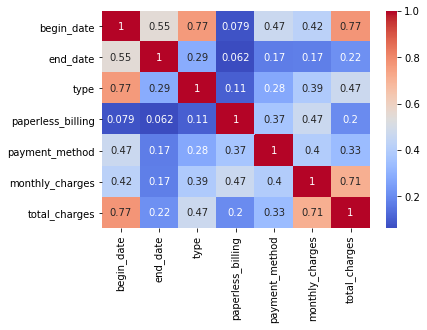

In [15]:
df_contract_wid = df_contract.drop('customer_id', axis=1)

ph_matrix = phik_matrix(df_contract_wid)
sns.heatmap(ph_matrix, cmap='coolwarm', annot=True)
plt.show()

Можно увидеть, что самые высокие значения в матрице 0.77 между столбцами с датами начала и столбцами итоговых трат. Думаю, что это напрямую зависит от графика платежей за услуги. Также высокое значение корреляции 0.77 у данных с типом оплаты со столбцами дат начала договоров.

Построим гистограммы столбцов с численными данными `monthly_charges` и `total_charges `, тем самым посмотрим на распределение данных в этих столбцах

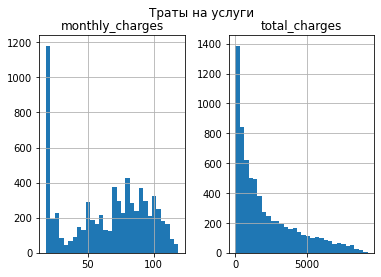

In [16]:
numeric_columns = ['monthly_charges', 'total_charges']
df_contract[numeric_columns].hist(bins=30)  
plt.suptitle('Траты на услуги')
plt.show()

У столбца `total_charges` распределение нормальное нисходящее, а вот у столбца `monthly_charges` распределение ненормальное, слишком много значений около 0. Рассмотрим его поближе построив боксплот.

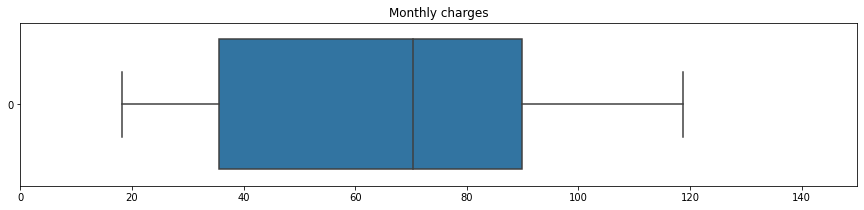

In [17]:
#посмотрим на боксплот
plt.figure(figsize=(15,3))
sns.boxplot(data=df_contract.monthly_charges, orient='h')
plt.xlim(0, 150) 
plt.title('Monthly charges')
plt.show()

На боксплоте все выглядит куда лучше: выбросов нет, нулевых значений тоже нет, большинство значений лежит в диапазоне от 37 до 90.

Посмотрим на распределение значений в столбцах с категориальными данными. Для этого построим для каждого столбца гистограмму.

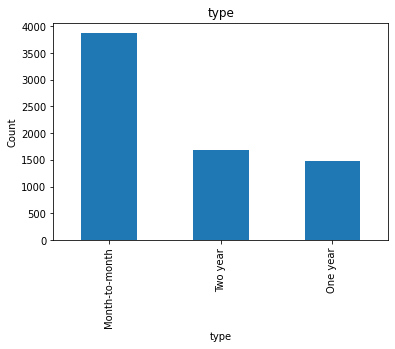

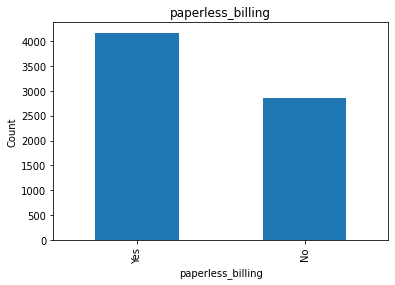

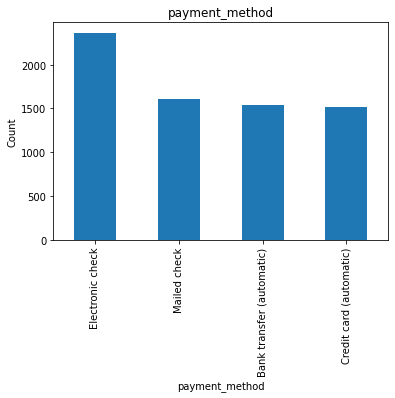

In [18]:
#выделим в отдельную переменную столбцы с категориальными данными
categorical_columns = ['type', 'paperless_billing', 'payment_method', ]

#напишем цикл для построения гистограммы для каждого столбца из переменной выше
for column in categorical_columns:
    plt.figure()
    df_contract[column].value_counts().plot(kind='bar')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

*Вывод*: 

- по типу оплаты: половина всех пользователей платят ежемесячно. Остальные, которые платят единоразово за год или за два года сразу - поровну;

- по электронному платежному документу: 60% получают, остальные - нет;

- по способу оплаты: тут чуть больше пользователей оплачивающих по электронному чеку, остальных же - оплачивающих по почтовому (на физическом носителе) чеку, автоматическим банковским переводом или автоматическим списанием с карты - поровну.

### Подготовка, визуализация и исследование данных второго датафрейма

In [19]:
#прочитаем датафрейм
df_personal = pd.read_csv('/datasets/personal_new.csv')

#выведем информацию 
get_data_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
3515,5206-HPJKM,Male,0,No,No
5143,5204-HMGYF,Female,0,Yes,Yes
2898,6505-OZNPG,Female,0,No,No
2734,2371-JUNGC,Male,0,No,No
4459,3178-FESZO,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Как и в первом датафрейме во втором также 7043 строки. Пропуски в данном датафрейме отсутствуют. Все столбцы со строковыми значениями, кроме столбца SeniorCitizen -  в нем числовые данные. Менять типы данных в столбцах нет необходимости. Переименуем названия столбцов согласно правилам PEP-8.

In [20]:
#переведем названия в нижний регистр
df_personal.columns = df_personal.columns.str.lower()

#переименуем их
df_personal = df_personal.rename(columns = {'customerid':'customer_id', 
                                          'seniorcitizen': 'senior_citizen'})

#проверяем
df_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [21]:
#проверим на всякий случай явные дубликаты в столбце customer_id
df_personal['customer_id'].duplicated().sum()

0

Посмотрим корреляцию в phik-матрице

interval columns not set, guessing: ['senior_citizen']


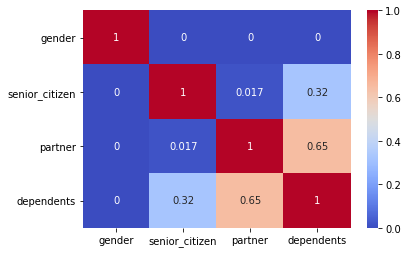

In [22]:
df_personal_wid = df_personal.drop('customer_id', axis=1)

ph_matrix = phik_matrix(df_personal_wid)
sns.heatmap(ph_matrix, cmap='coolwarm', annot=True)
plt.show()

Высокая корреляция как и ожидалось только у столбцов с данными по наличию супруга(супруги) (`partner`) и с данными по количеству иждевенцов (`dependents`)

Посмотрим на распределение данных в столбцах. Для этого построим для каждого столбца (кроме столбца `customer_id`) гистограмму. Первым столбцом, по которому построим гистограмму будет столбец с числовыми данными - `senior_citizen` (Наличие пенсионного статуса по возрасту).

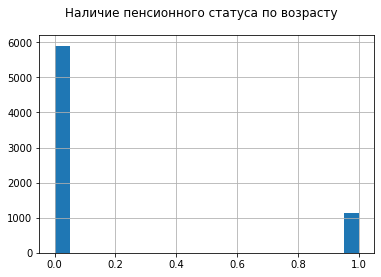

In [23]:
df_personal['senior_citizen'].hist(bins=20)  
plt.suptitle('Наличие пенсионного статуса по возрасту')
plt.show()

Видим, что только у 10% пользователей если наличие пенсионного статуса по возрасту

Посмотрим на распределение значений в столбцах с категориальными данными

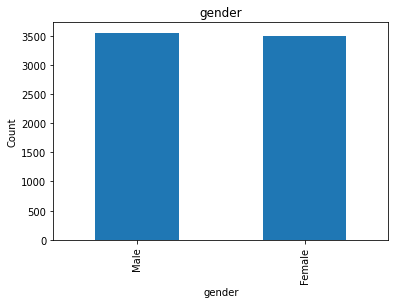

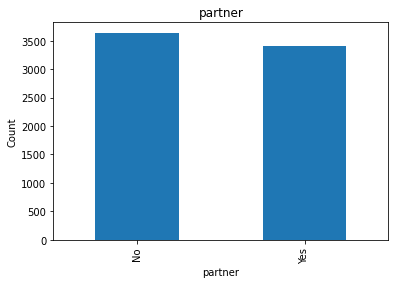

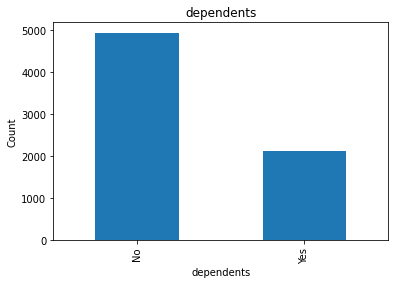

In [24]:
#выделим в отдельную переменную столбцы с категориальными данными
categorical_columns = ['gender', 'partner', 'dependents', ]

#напишем цикл для построения гистограммы для каждого столбца из переменной выше
for column in categorical_columns:
    plt.figure()
    df_personal[column].value_counts().plot(kind='bar')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

Вывод:

по полу: мужчин и женщин - одинаковое количество;

по наличию супруга(супруги): у чуть больше чем половины пользователей есть супруг;

по наличию иждивенцов: у большинства (около 70%) есть иждивенцы.

### Подготовка, визуализация и исследование данных третьего датафрейма

In [25]:
#прочитаем датафрейм
df_internet = pd.read_csv('/datasets/internet_new.csv')

#выведем информацию 
get_data_info(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
210,7529-ZDFXI,Fiber optic,No,Yes,No,No,No,Yes
5338,5868-YWPDW,Fiber optic,No,Yes,No,No,No,Yes
2461,4236-XPXAV,Fiber optic,No,Yes,No,Yes,Yes,Yes
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
483,5172-MIGPM,DSL,No,No,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0786-VSSUD,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


В третьем датафрейме 5517 строк. Это значит, что не все пользователи пользуются интернет услугами. Пропуски в данном датафрейме отсутствуют. В данном датафрейме только категориальные признаки. Менять типы данных в столбцах нет необходимости. Переименуем названия столбцов согласно правилам PEP-8.

In [26]:
#переведем названия в нижний регистр
df_internet.columns = df_internet.columns.str.lower()

#переименуем их
df_internet = df_internet.rename(columns = {'customerid':'customer_id', 
                                          'internetservice': 'internet_service',
                                          'onlinesecurity': 'online_security',
                                          'onlinebackup': 'online_backup',
                                          'deviceprotection': 'device_protection',
                                          'techsupport': 'tech_support',
                                          'streamingtv': 'streaming_tv',
                                          'streamingmovies': 'streaming_movies',})

#проверяем'onlinebackup': 'online_backup',
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [27]:
#проверим на всякий случай явные дубликаты в столбце customer_id
df_internet['customer_id'].duplicated().sum()

0

Посмотрим корреляцию в phik-матрице

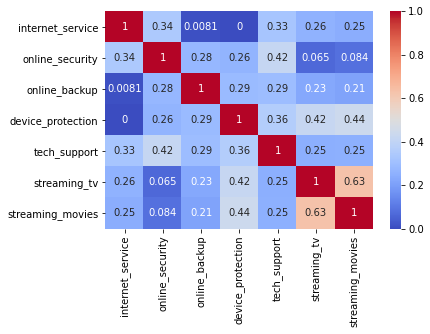

In [28]:
df_internet_wid = df_internet.drop('customer_id', axis=1)

ph_matrix = phik_matrix(df_internet_wid)
sns.heatmap(ph_matrix, cmap='coolwarm', annot=True)
plt.show()

Наличие высоких показателей корреляции наблюдается только между столбцами `streaming_tv` и `streaming_movies` и это неудивительно, потому что скорее всего те пользователи, которые пользуются сервисом потоковой трансляции каналов, также пользуются и сервисом потокового просмотра фильмов. Показатели между остальными данными низкие, что говорит об отсутствии корреляции между ними.

Посмотрим на распределение значений в столбцах, построив гистограммы

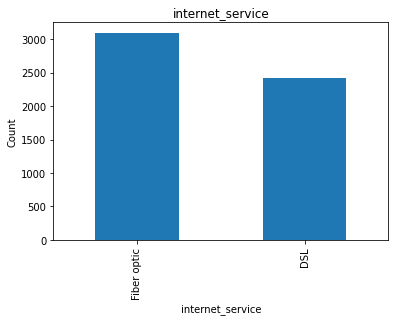

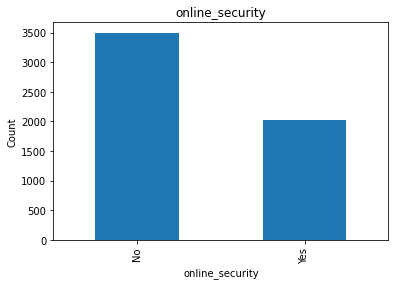

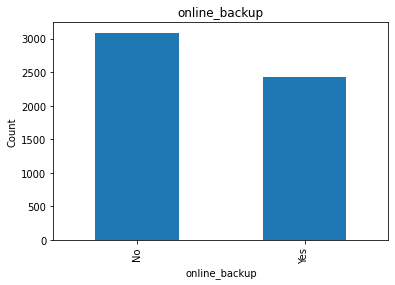

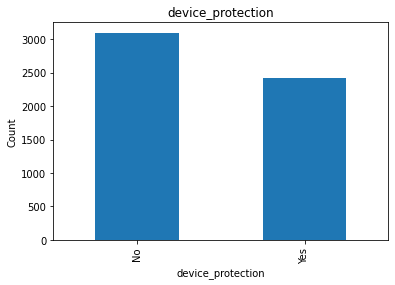

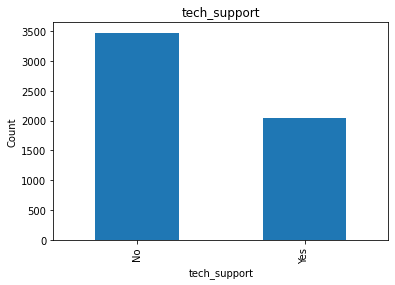

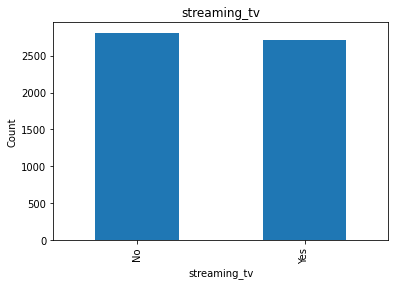

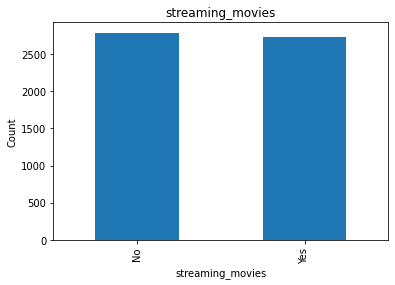

In [29]:
categorical_columns = ['internet_service', 'online_security', 'online_backup',
                       'device_protection', 'tech_support', 'streaming_tv','streaming_movies']
for column in categorical_columns:
    plt.figure()
    df_internet[column].value_counts().plot(kind='bar')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

*Вывод*:

по типу соединения: чуть больше чем у половины пользователей (~60%) интернет-соединение через оптоволокно, у остальных - DSL (абонентская линия);

по сервисам потоковых фильмов и потокового телевидения: поровну - половина пользуется, половина нет;

по остальным услугам можно сказать, что у около 40% пользователей интернета нашего оператора подключены доп. услуги.

### Подготовка, визуализация и исследование данных четвертого датафрейма

In [30]:
#прочитаем датафрейм
df_phone = pd.read_csv('/datasets/phone_new.csv')

#выведем информацию 
get_data_info(df_phone)

,customerID,MultipleLines
4040,1608-GMEWB,Yes
4281,0961-ZWLVI,Yes
4303,1319-YLZJG,No
5340,3229-USWAR,No
865,3261-CQXOL,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7449-HVPIV,No
freq,1,3390


В четвертом датафрейме 6361 строка. Это значит, что не все пользователи пользуются услугой телефонии от нашего оператора. Пропуски в данном датафрейме отсутствуют. В данном датафрейме только один категориальный признак, говорящий нам о наличии у пользователя доп. услуги о возможности ведения параллельных линий во время звонка. Переименуем названия столбцов согласно правилам PEP-8.

In [31]:
#переведем названия в нижний регистр
df_phone.columns = df_phone.columns.str.lower()

#переименуем их
df_phone = df_phone.rename(columns = {'customerid':'customer_id', 
                                          'multiplelines': 'multiple_lines'})

#проверяем'onlinebackup': 'online_backup',
df_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [32]:
#проверим на всякий случай явные дубликаты в столбце customer_id
df_internet['customer_id'].duplicated().sum()

0

Посмотрим на распределение значений в столбцe, построив гистограмму

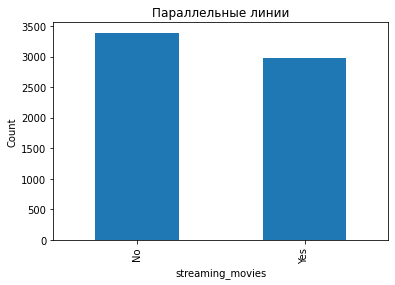

In [33]:
plt.figure()
df_phone['multiple_lines'].value_counts().plot(kind='bar')
plt.title('Параллельные линии')
plt.xlabel(column)
plt.ylabel('Count')
plt.show()

Чуть больше чем половина пользователей (~60%) доп. услугой возможности ведения параллельных линий во время звонка не пользуются

*Вывод*: у нас в работе четыре датафрейма два из которых с одинаковым количеством строк и которые отражают общее количество пользователей, остальные два датафрейма показывают нам количество пользователей, которые пользуются либо интернетом от нашего оператора, либо телефонной связью. Количество строк в двух последних датафреймах разное, что означает, что не все пользователи, которые пользуется например интернетом, пользуются также телефонной связью и наоборот. Во второй части проекта мы объединим все датафреймы в один , добавим целевой показатель и избавимся от ненужных столбцов.

## Выбор лучшей модели

###  Объединение данных

Объединим все предоставленные датафреймы в один общий

In [34]:
df_united = df_contract.join(df_personal.set_index('customer_id'), on='customer_id', how='left')
df_united = df_united.join(df_internet.set_index('customer_id'), on='customer_id', how='left')
df_united = df_united.join(df_phone.set_index('customer_id'), on='customer_id', how='left')

#проверим
df_united.info(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   5512 non-null   object        
 13  online_security    5512 non-null   object        
 14  online_b

Теперь переведем `end_date` в тип datetime, но для начала заменим значение 'No' в данном столбце на дату выгрузки датасета  - 2020-02-01

In [35]:
#заменяем значение No
df_united['end_date'] = df_united['end_date'].where(df_united['end_date']!= 'No', '2020-02-01')

#переводим в datetime
df_united['end_date'] = pd.to_datetime(df_united['end_date'], format='%Y.%m.%d', errors='coerce')

#проверим
df_united.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   5512 non-null   object        
 13  online_security    5512 non-null   object        
 14  online_b

Добавим целевой признак `df_united['target']` следующим образом: в тех строках, в которых мы поменяли 'No' на дату выгрузки в столбце `end_date`, проставим 1, т.е. клиент еще пользуется услугами оператора на дату выгрузки, в тех строках в которых стоит дата окончания договора отличная от даты выгрузки - 0, т.е. клиент точно уже расторг договор.

In [36]:
df_united['exited'] = (df_united['end_date'] == '2020-02-01').astype(int)

#проверим
df_united.sample(15)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
4905,3359-DSRKA,2015-04-01,2018-11-01,Two year,Yes,Mailed check,19.85,853.55,Female,0,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6851,8465-SBRXP,2016-12-01,2020-02-01,Two year,Yes,Bank transfer (automatic),94.90,3642.26,Male,0,...,Yes,Fiber optic,No,No,Yes,Yes,Yes,No,Yes,1
2939,8802-UNOJF,2018-12-01,2020-02-01,Month-to-month,Yes,Mailed check,83.80,1255.32,Male,1,...,No,Fiber optic,No,Yes,Yes,Yes,No,No,No,1
4726,2192-CKRLV,2014-02-01,2020-02-01,Two year,Yes,Electronic check,49.20,3542.40,Female,0,...,No,DSL,Yes,Yes,Yes,No,No,Yes,NaN,1
5884,4785-QRJHC,2016-03-01,2020-02-01,One year,Yes,Bank transfer (automatic),59.90,2843.45,Male,1,...,No,DSL,No,Yes,Yes,Yes,Yes,Yes,NaN,1
2617,4588-YBNIB,2019-11-01,2020-02-01,Month-to-month,Yes,Mailed check,19.60,64.09,Female,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1
311,7277-OZCGZ,2018-04-01,2020-02-01,Month-to-month,Yes,Electronic check,89.05,2057.05,Female,0,...,No,Fiber optic,Yes,No,No,Yes,No,Yes,No,1
5110,8541-QVFKM,2019-06-01,2020-02-01,Month-to-month,Yes,Electronic check,73.50,635.04,Female,0,...,No,Fiber optic,No,No,No,No,No,No,Yes,1
3744,9040-KZVWO,2017-12-01,2020-02-01,One year,No,Bank transfer (automatic),75.50,2041.52,Male,0,...,No,Fiber optic,No,Yes,No,No,No,No,No,1
5553,6629-CZTTH,2019-12-01,2020-02-01,Month-to-month,Yes,Mailed check,55.70,114.74,Male,0,...,No,DSL,No,No,No,No,No,Yes,No,1


Добавим новый признак такой как продолжительность (duration) для этого вычтим из даты окончания по договору дату начала договора

In [37]:
df_united['duration'] = (df_united['end_date'] - df_united['begin_date'] ).dt.days
#проверим
df_united.sample(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,duration
2477,1212-GLHMD,2019-11-01,2020-02-01,Month-to-month,Yes,Mailed check,86.05,263.31,Male,0,...,Fiber optic,Yes,No,No,No,No,Yes,No,1,92
1183,0887-WBJVH,2015-09-01,2020-02-01,One year,Yes,Electronic check,93.45,5448.14,Female,0,...,Fiber optic,No,No,No,Yes,Yes,Yes,No,1,1614
5076,1644-IRKSF,2017-01-01,2018-05-01,One year,Yes,Electronic check,93.80,1635.87,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,No,0,485
324,8626-PTQGE,2014-05-01,2017-12-01,Two year,Yes,Bank transfer (automatic),60.05,2582.15,Male,0,...,DSL,Yes,Yes,No,Yes,Yes,Yes,NaN,0,1310
2042,7361-YPXFS,2017-10-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),64.45,1858.74,Female,1,...,DSL,No,Yes,Yes,Yes,No,No,Yes,1,853
4436,3639-XJHKQ,2018-07-01,2020-02-01,Month-to-month,Yes,Electronic check,60.60,1197.46,Female,0,...,DSL,Yes,Yes,Yes,No,No,No,No,1,580
6601,4909-JOUPP,2014-02-01,2020-02-01,Two year,No,Credit card (automatic),109.70,8293.32,Male,1,...,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,1,2191
1406,9337-SRRNI,2014-08-01,2019-05-01,Two year,Yes,Credit card (automatic),25.30,1442.10,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,1734
2030,3090-LETTY,2019-12-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),60.95,121.90,Male,0,...,DSL,Yes,Yes,No,No,No,No,Yes,1,62
2677,2608-BHKFN,2019-06-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),70.05,560.40,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,245


После удалим уже не нужные нам столбцы

In [38]:
df_united = df_united.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

Посмотрим корреляцию объединенного датафрейма в phik-матрице

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'exited', 'duration']


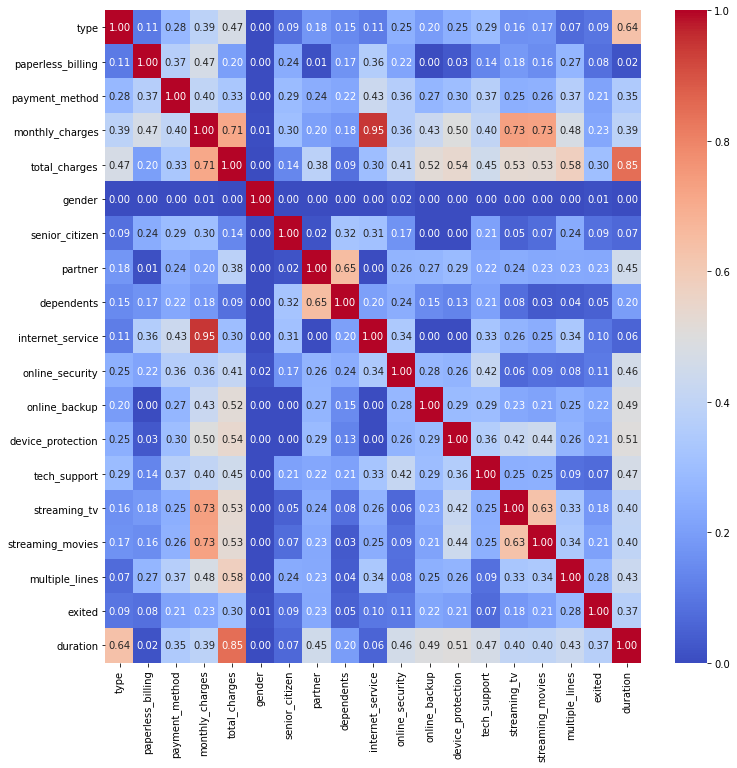

In [39]:
ph_matrix = phik_matrix(df_united)
plt.figure(figsize=(12, 12))  
sns.heatmap(ph_matrix, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size': 10}) 
plt.show()

Из полученной матрицы видно, что между собой коррелируют `total_charges` со столбцом `duration`, но это в принципе и логично: чем больше продолжительность договорных отношений, тем больше итоговые затраты клиента по договору. Также замечена более, чем умеренная взаимосвязь между столбцами `streaming_tv`, `streaming_movies` и `monthly_charges`: возможно это связано с тем, что  стриминги составляют большую долю в ежемесячных затратах тех клиентов у которых подключены данные услуги. У остальных показателей умеренная или нормальная корреляция. 

Также одинаковые показатели у столбцов `streaming_tv` и `streaming_movies`, в связи с этим думаю, что можно удалить один из этих столбцов и этим столбцом будет `streaming_tv`. 

In [40]:
df_united = df_united.drop(['streaming_tv'], axis=1)

Заменим появившиеся пропуски после объединения значением "not_used"

In [41]:
df_united = df_united.fillna('not_used')

###  Разбиение на выборки

Наши данные содержат помимо численных признаков также и категориальные признаки. Преобразуем категориальные признаки в численные методом прямого кодирования (OHE). Данная техника подходит для решения нашей задачи, а также работает со всеми моделями. Но сначала разобьем датафрейм на выборки.

In [42]:
#создадим копию объединенного датафрейма
df_united_ohe = df_united.copy()

In [43]:
#выделим категориальные и численные признаки в переменные
cat_cols = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 
           'partner', 'dependents', 'internet_service', 'online_security', 'online_backup',
           'device_protection', 'tech_support', 'streaming_movies', 'multiple_lines', 'senior_citizen']

num_cols = ['monthly_charges', 'total_charges',  'duration']

Далее разобьем датафрейм на выборки

In [45]:
#выделим признаки и целевой признак 
features = df_united_ohe.drop('exited', 1)
target = df_united_ohe['exited']

#разобьем признаки и целевой признак на 2 группы, отделив обучающие данные от тестовых + валидационных
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

#проверим
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(5274, 17)

(1758, 17)

(5274,)

(1758,)

In [46]:
#преобразуем кат. признаки методом OHE
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

ohe.fit(features_train[cat_cols])

new_cols = ohe.get_feature_names(cat_cols)

features_train_ohe = pd.DataFrame(ohe.transform(features_train[cat_cols]).toarray(), 
                                  columns=new_cols, index=features_train.index)
features_test_ohe = pd.DataFrame(ohe.transform(features_test[cat_cols]).toarray(),
                                 columns=new_cols, index=features_test.index)

features_train_ohe = features_train_ohe.join(features_train[num_cols])
features_test_ohe = features_test_ohe.join(features_test[num_cols])

#проверим
display(features_train_ohe.head(5))
display(features_train_ohe.head(5))

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,...,tech_support_Yes,tech_support_not_used,streaming_movies_Yes,streaming_movies_not_used,multiple_lines_Yes,multiple_lines_not_used,senior_citizen_1,monthly_charges,total_charges,duration
2242,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,24.85,1093.4,1340
2547,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,39.10,2033.2,1584
2040,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,90.55,2173.2,731
5008,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,19.65,117.9,184
597,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,65.55,262.2,123


,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,...,tech_support_Yes,tech_support_not_used,streaming_movies_Yes,streaming_movies_not_used,multiple_lines_Yes,multiple_lines_not_used,senior_citizen_1,monthly_charges,total_charges,duration
2242,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,24.85,1093.4,1340
2547,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,39.10,2033.2,1584
2040,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,90.55,2173.2,731
5008,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,19.65,117.9,184
597,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,65.55,262.2,123


Далее масштабируем признаки методом стандартизации

In [47]:
num_cols = ['monthly_charges', 'total_charges', 'duration']

#cоздадим объект и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train_ohe[num_cols])

pd.options.mode.chained_assignment = None

features_train_ohe[num_cols] = scaler.transform(features_train_ohe[num_cols])
features_test_ohe[num_cols] = scaler.transform(features_test_ohe[num_cols])

### Поиск лучшей метрики на тренировочной выборке

Обучаем модель логистической регрессии

In [48]:
#создаем объект
params_lr = {'penalty' : ['l1','l2'], 
             'solver'  : ['newton-cg', 'lbfgs', 'liblinear'], 
             'random_state':[RANDOM_STATE]
            }

model_lr = LogisticRegression()

grid = GridSearchCV(model_lr, param_grid=params_lr, scoring='roc_auc', cv=3, verbose=True)

#обучаем модель
best_grid = grid.fit(features_train_ohe, target_train)

roc_auc_lr = best_grid.best_score_

display("Наилучшие гиперпараметры для ROC-AUC:", grid.best_params_)
display("ROC-AUC: {:.2f}".format(best_grid.best_score_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


'Наилучшие гиперпараметры для ROC-AUC:'

{'penalty': 'l2', 'random_state': 170723, 'solver': 'newton-cg'}

'ROC-AUC: 0.77'

Обучение модели RandomForestClassifier

In [49]:
params_forest = {
    'n_estimators': [1,50, 100, 150],
    'max_depth': [1,10,50, 100],
    'random_state':[RANDOM_STATE]
}

model_forest = RandomForestClassifier()
                                 
grid_roc = GridSearchCV(model_forest, param_grid=params_forest, scoring='roc_auc', cv=3, verbose=True)

best_grid = grid_roc.fit(features_train_ohe, target_train)

roc_auc_rfc = best_grid.best_score_

display("Наилучшие гиперпараметры для ROC-AUC:", grid_roc.best_params_)
display("ROC-AUC: {:.2f}".format(grid_roc.best_score_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


'Наилучшие гиперпараметры для ROC-AUC:'

{'max_depth': 10, 'n_estimators': 150, 'random_state': 170723}

'ROC-AUC: 0.82'

In [50]:
params_catboost = {
    'iterations': [100, 300, 500],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'depth': [3, 6, 9],  
    'random_state': [RANDOM_STATE]
}

catboost_model = CatBoostClassifier()

grid = GridSearchCV(catboost_model, param_grid=params_catboost, scoring='roc_auc', cv=5, verbose=1000)

best_grid = grid.fit(features_train, target_train, cat_features=cat_cols)

roc_auc_cbc = best_grid.best_score_

display("Наилучшие гиперпараметры для ROC-AUC:", best_grid.best_params_)
display("ROC-AUC: {:.2f}".format(best_grid.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START depth=3, iterations=100, learning_rate=0.01, random_state=170723
0:	learn: 0.6881324	total: 50ms	remaining: 4.95s
1:	learn: 0.6832005	total: 52.3ms	remaining: 2.56s
2:	learn: 0.6785268	total: 54.1ms	remaining: 1.75s
3:	learn: 0.6737423	total: 56.3ms	remaining: 1.35s
4:	learn: 0.6693262	total: 58.3ms	remaining: 1.11s
5:	learn: 0.6649794	total: 60.7ms	remaining: 952ms
6:	learn: 0.6604573	total: 63.6ms	remaining: 845ms
7:	learn: 0.6560368	total: 65.6ms	remaining: 754ms
8:	learn: 0.6517680	total: 67.2ms	remaining: 680ms
9:	learn: 0.6476457	total: 69.3ms	remaining: 624ms
10:	learn: 0.6436513	total: 71.8ms	remaining: 581ms
11:	learn: 0.6396447	total: 73.7ms	remaining: 541ms
12:	learn: 0.6356458	total: 75.5ms	remaining: 505ms
13:	learn: 0.6319314	total: 77.4ms	remaining: 475ms
14:	learn: 0.6282000	total: 79.1ms	remaining: 448ms
15:	learn: 0.6245545	total: 80.9ms	remaining: 425ms
16:	learn: 0.6208543	total: 82.7

'Наилучшие гиперпараметры для ROC-AUC:'

{'depth': 3, 'iterations': 500, 'learning_rate': 0.2, 'random_state': 170723}

'ROC-AUC: 0.91'

Сведем в датафрейм 

In [51]:
index=['Логистическая регрессия', 'RandomForestClassifier', 'CatBoostClassifier']
data={'ROC-AUC':[roc_auc_lr, roc_auc_rfc, roc_auc_cbc]}
analyze = pd.DataFrame(data=data, index=index)
analyze

,ROC-AUC
Логистическая регрессия,0.766246
RandomForestClassifier,0.816931
CatBoostClassifier,0.912733


Лучшие показатели дала модель CatBoostClassifier. Ее и протестируем.

##  Тестирование модели

### Тестирование лучшей модели на тестовой выборке

In [52]:
#создаем CatBoostClassifier с лучшими гиперпараметрами
catboost_model = CatBoostClassifier(depth=3, iterations=500, learning_rate=0.2, random_state=RANDOM_STATE)

#обучим модель на всей обучающей выборке
catboost_model.fit(features_train, target_train, cat_features=cat_cols)

#предскажем вероятности классов на тестовой выборке
y_pred_prob = catboost_model.predict_proba(features_test)[:, 1]
predicted_test = catboost_model.predict(features_test)

#считаем ROC-AUC
roc_auc = roc_auc_score(target_test, y_pred_prob)
display("ROC-AUC на тестовой выборке: {:.2f}".format(roc_auc))

#считаем accuracy
accuracy = accuracy_score(target_test, predicted_test)
display("Accuracy на тестовой выборке: {:.2f}".format(accuracy))

0:	learn: 0.5787248	total: 6.78ms	remaining: 3.38s
1:	learn: 0.4950411	total: 12.8ms	remaining: 3.2s
2:	learn: 0.4451589	total: 18.7ms	remaining: 3.09s
3:	learn: 0.4077799	total: 24.8ms	remaining: 3.08s
4:	learn: 0.3877940	total: 30.4ms	remaining: 3.01s
5:	learn: 0.3778943	total: 35.9ms	remaining: 2.96s
6:	learn: 0.3688349	total: 42ms	remaining: 2.96s
7:	learn: 0.3608631	total: 47ms	remaining: 2.89s
8:	learn: 0.3534303	total: 52.6ms	remaining: 2.87s
9:	learn: 0.3505858	total: 58ms	remaining: 2.84s
10:	learn: 0.3465077	total: 63.6ms	remaining: 2.83s
11:	learn: 0.3443803	total: 68.2ms	remaining: 2.77s
12:	learn: 0.3427701	total: 73.2ms	remaining: 2.74s
13:	learn: 0.3375329	total: 79.1ms	remaining: 2.74s
14:	learn: 0.3362482	total: 84.2ms	remaining: 2.72s
15:	learn: 0.3338966	total: 89.2ms	remaining: 2.7s
16:	learn: 0.3325746	total: 93.7ms	remaining: 2.66s
17:	learn: 0.3313704	total: 99.5ms	remaining: 2.66s
18:	learn: 0.3295865	total: 104ms	remaining: 2.62s
19:	learn: 0.3280748	total: 109

'ROC-AUC на тестовой выборке: 0.92'

'Accuracy на тестовой выборке: 0.92'

### Визуализация данных

Построим ROC-кривую для обученной модели и изобразим её на графике

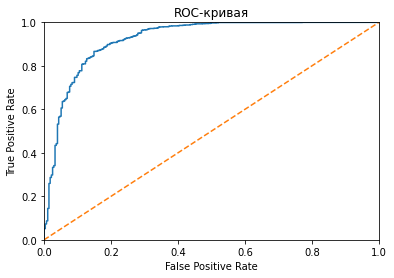

In [53]:
fpr, tpr, thresholds = roc_curve(target_test, y_pred_prob)

plt.figure()

#построим график
plt.plot(fpr, tpr)

#ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

#установим границы осей от 0 до 1 
plt.ylim([0, 1])
plt.xlim([0, 1])

#подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#добавим к графику заголовок "ROC-кривая"
plt.title('ROC-кривая')

plt.show()

Построим матрицу ошибок

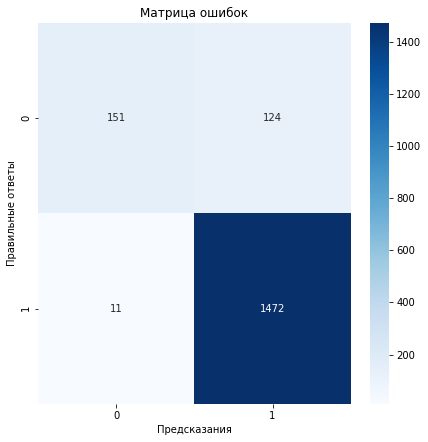

In [54]:
cmatrix = confusion_matrix(target_test, predicted_test)

plt.figure(figsize=(7, 7))
sns.heatmap(cmatrix, annot=True,  cmap='Blues', 
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show()

Визуализируем важность признаков.

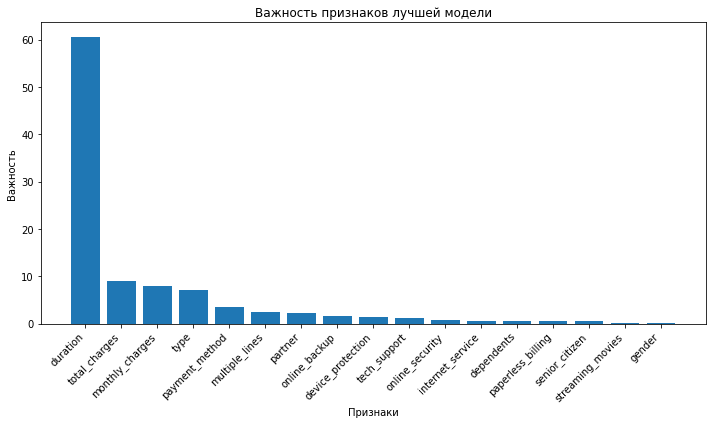

,Importance
duration,60.606673
total_charges,8.898731
monthly_charges,8.001938
type,7.185469
payment_method,3.587040
multiple_lines,2.377282
partner,2.206690
online_backup,1.568131
device_protection,1.471056
tech_support,1.163923


In [55]:
feature_importance = catboost_model.get_feature_importance()

#получим названия признаков
feature_names = features_train.columns

#отсортируем признаки по важности в убывающем порядке
sorted_idx = feature_importance.argsort()[::-1]

#визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=45, ha='right')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков лучшей модели')
plt.tight_layout()
plt.show()

pd.DataFrame(data=feature_importance, index=feature_names, columns=['Importance']).sort_values(by='Importance', ascending=False)

## Итоговый вывод

Была проведена предобработка предоставленных данных: приведены к одному регистру наименования столбцов. Также названия столбцов были переименованы. Были удалены пропуски в столбце `total_charges`. Категориальные признаки данных были переведены в численные методом прямого кодирования (OHE) и масштабированы. 

Были исследованы три модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier. Наилучшую эффективность показала модель CatBoostClassifier с гиперпараметрами depth=3, iterations=500, learning_rate=0.2. CatBoostClassifier была проверена на тестовой выборке и показала значение метрики ROC-AUC = 0.92, что выше заявленного в задаче порога - 0.85. Значение метрики accuracy = 0.92.

Исходя матрицы ошибок лучшей модели CatBoostClassifier, можно сделать следующие выводы:

Модель совершает меньше ложно-отрицательных ошибок (FN=11) по сравнению с ложно-положительными ошибками (FP=124). Это говорит о том, что модель лучше предсказывает клиентов, которые остаются, чем тех, кто уходит.

Общее количество правильных предсказаний (TP + TN) является довольно высоким (1472 + 151 = 1623), что может указывать на хорошую общую производительность модели.

Однако, стоит обратить внимание на небольшое количество ложно-положительных ошибок (FP=124), что может привести к ненужным затратам на удержание клиентов, которые фактически остаются.

На основании значений важности признаков, полученных от модели CatBoostClassifier, можно сделать следующие выводы:

duration: Этот признак имеет наибольшую важность (60.61), что говорит о том, что длительность контракта является наиболее сильным предиктором ухода клиентов. Чем дольше контракт, тем более вероятно, что клиент останется с компанией.

total_charges и monthly_charges: Эти признаки также имеют высокую важность (8.90 и 8.00 соответственно). Высокие общие и ежемесячные затраты на услуги могут быть связаны с более лояльными клиентами, которые склонны оставаться с компанией.

type: Тип контракта (7.19) также оказывает значительное влияние на решения клиентов об уходе. Вероятно, разные типы контрактов имеют различные условия и характеристики, которые влияют на поведение клиентов.

payment_method: Метод оплаты (3.59) может влиять на решения клиентов об уходе. Некоторые методы оплаты могут быть удобнее и привлекательнее для клиентов, что сказывается на их решениях об оставлении или уходе.

multiple_lines, partner, online_backup, device_protection, tech_support, online_security, internet_service, dependents, paperless_billing, senior_citizen, streaming_movies, gender: Эти признаки имеют низкую важность по сравнению с предыдущими, что может означать, что они менее значимы для прогнозирования ухода клиентов. Возможно, для улучшения модели стоит обратить внимание на данные признаки и попробовать использовать другие методы кодирования, масштабирования или преобразования.

# Отчет #

Все этапы запланированных и согласованных действий успешно выполнены без отклонений

В процессе выполнения проекта, я столкнулся с несколькими трудностями, однако главной из них оказалась установленная цель проекта — достижение бизнес-метрики ROC-AUC больше 0.85. 

Для этого я сосредоточился на оптимизации модели CatBoostClassifier, которая представляла собой наиболее подходящий выбор для данной задачи. Моя главная работа заключалась в тщательном подборе гиперпараметров модели, чтобы достичь наилучшего сочетания между точностью и обобщающей способностью модели.

Процесс настройки гиперпараметров был тщательным и времязатратным, поскольку требовалось учитывать различные факторы, такие как переобучение, скорость обучения и размер деревьев. Множество итераций и экспериментов было проведено, чтобы найти оптимальные значения гиперпараметров, которые привели к достижению желаемой ROC-AUC выше 0.85.


Основными шагами, которые привели к получению высококачественной модели, стали:

Анализ исходных данных для полного понимания их структуры и особенностей.

Создание дополнительных признаков и выделение целевого признака.

Динамический подбор гиперпараметров модели с использованием кросс-валидации, чтобы найти оптимальные значения параметров и обеспечить хорошую обобщающую способность модели.

Была проведена предобработка предоставленных данных: приведены к одному регистру наименования столбцов. Также названия столбцов были переименованы. Были удалены пропуски в столбце total_charges. Категориальные признаки данных были переведены в численные методом прямого кодирования (OHE) и масштабированы. 

Был создан целевой признак `exited` и также был создан признак `duration`. После создания признака `duration` были удалены столбцы `end_date` и `begin_date`.

Наилучшую эффективность показала модель CatBoostClassifier с гиперпараметрами depth=3, iterations=500, learning_rate=0.2, random_state=17072023. CatBoostClassifier была проверена на тестовой выборке и показала значение метрики ROC-AUC = 0.92, что выше заявленного в задаче порога - 0.85. Значение метрики accuracy = 0.92.

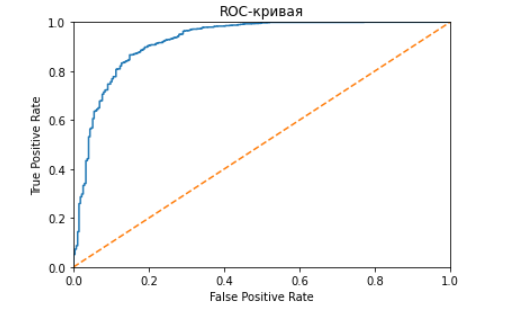

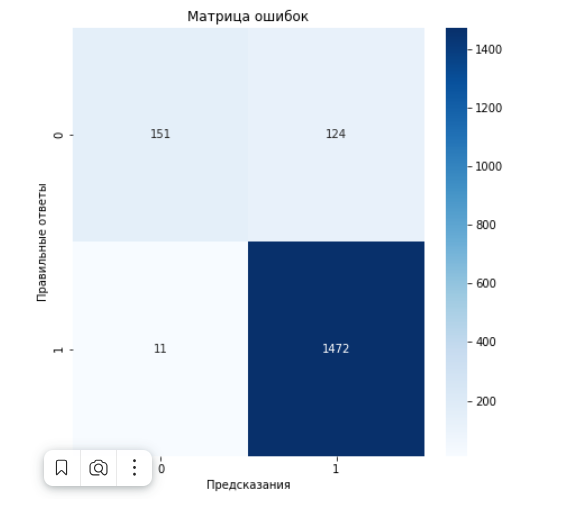

Исходя матрицы ошибок лучшей модели CatBoostClassifier, можно сделать следующие выводы:

Модель совершает меньше ложно-отрицательных ошибок (FN=11) по сравнению с ложно-положительными ошибками (FP=124). Это говорит о том, что модель лучше предсказывает клиентов, которые остаются, чем тех, кто уходит.

Общее количество правильных предсказаний (TP + TN) является довольно высоким (1472 + 151 = 1623), что может указывать на хорошую общую производительность модели.

Однако, стоит обратить внимание на небольшое количество ложно-положительных ошибок (FP=124), что может привести к ненужным затратам на удержание клиентов, которые фактически остаются.

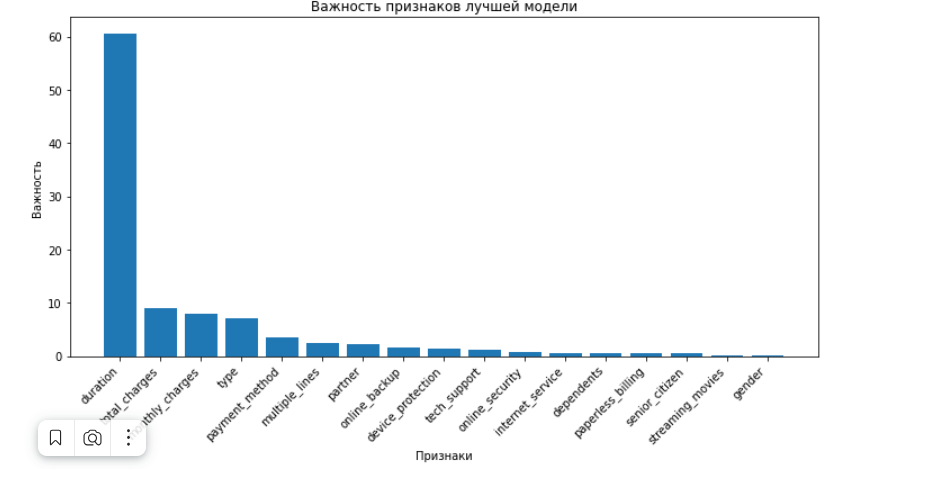

На основании значений важности признаков, полученных от модели CatBoostClassifier, можно сделать следующие выводы:

duration: Этот признак имеет наибольшую важность (60.61), что говорит о том, что длительность контракта является наиболее сильным предиктором ухода клиентов. Чем дольше контракт, тем более вероятно, что клиент останется с компанией.

total_charges и monthly_charges: Эти признаки также имеют высокую важность (8.90 и 8.00 соответственно). Высокие общие и ежемесячные затраты на услуги могут быть связаны с более лояльными клиентами, которые склонны оставаться с компанией.

type: Тип контракта (7.19) также оказывает значительное влияние на решения клиентов об уходе. Вероятно, разные типы контрактов имеют различные условия и характеристики, которые влияют на поведение клиентов.

payment_method: Метод оплаты (3.59) может влиять на решения клиентов об уходе. Некоторые методы оплаты могут быть удобнее и привлекательнее для клиентов, что сказывается на их решениях об оставлении или уходе.

multiple_lines, partner, online_backup, device_protection, tech_support, online_security, internet_service, dependents, paperless_billing, senior_citizen, streaming_movies, gender: Эти признаки имеют низкую важность по сравнению с предыдущими, что может означать, что они менее значимы для прогнозирования ухода клиентов. Возможно, для улучшения модели стоит обратить внимание на данные признаки и попробовать использовать другие методы кодирования, масштабирования или преобразования.